# Marcin Socha nr 418253

Na początku zaimportujmy potrzebne biblioteki, pliki z danymi oraz lata, ktorych mają dotyczyć analizy.

In [1]:
import pandas as pd

# Wyświetlenie przekazanych nazw plików
print(f"Wczytano plik GDP: {gdp_filename}")
print(f"Wczytano plik Population: {population_filename}")

# Wyświetlenie wprowadzonych liczb
print(f"Pierwsza liczba: {pocz}")
print(f"Druga liczba: {kon}")

# Wczytywanie plików CSV i wyświetlanie nazw kolumn
try:
    GDP = pd.read_csv(gdp_filename)
    pop = pd.read_csv(population_filename)

    # Wyświetlanie nazw kolumn
    print(f"Kolumny w pliku GDP ({gdp_filename}):")
    print(GDP.columns)

    print(f"Kolumny w pliku Population ({population_filename}):")
    print(pop.columns)

except FileNotFoundError as e:
    print(f"Błąd: {e}")
except pd.errors.EmptyDataError:
    print("Błąd: Jeden z plików CSV jest pusty.")


In [1]:
import pandas as pd
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
import external_func
importlib.reload(external_func)
import external_func as ef
import cProfile

In [2]:
#Teraz wczytujemy odczytujemy nazwy plików oraz zapisujemy dane z folderu do tabeli pliki = {}

folder = 'data'
nazwy_plikow = ef.pobierz_nazwy_plikow(folder)
print(nazwy_plikow)
pliki = {}
for nazwa_pliku in nazwy_plikow:
   ef.wczytaj_dane(folder, nazwa_pliku, pliki)


['title.ratings.tsv', 'title.principals.tsv', 'title.akas.tsv', 'name.basics.tsv', 'title.basics.tsv', 'title.episode.tsv', 'title.crew.tsv']


/Users/machoranis/Programowanie/NYPD/NYPD-Final_project/external_func.py:16: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(pelna_nazwa, sep='\t')


Sprawdzamy nazwy plików...

In [11]:
# pocz = '1960'
# kon = '2020'
klucze = [s[:-4].replace('.', '_') for s in nazwy_plikow]
klucze

['title_ratings',
 'title_principals',
 'title_akas',
 'name_basics',
 'title_basics',
 'title_episode',
 'title_crew']

... oraz nazwy kolumn w nich zawarte.

In [4]:
for i in range(len(klucze)):
    print(pliki[klucze[i]].columns)

Index(['tconst', 'averageRating', 'numVotes'], dtype='object')
Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')
Index(['titleId', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle'],
      dtype='object')
Index(['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession',
       'knownForTitles'],
      dtype='object')
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')
Index(['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'], dtype='object')
Index(['tconst', 'directors', 'writers'], dtype='object')


# Tworzenie metryki
Uznałem, ze najlepszą metryką będzie średnia harmoniczna z averageRating * log(numVotes), poniewaz srednia harmoniczna jest zawsze nizsza od sredniej arytmetycznej i dla stałej średniej arytmetyczniej osiąga maksimum gdy wszystkie oceny są równe, więc faworyzujemy niskie odchylenia. Z kolei log(numVotes), poniewaz wydaje się, ze jest to podobny poziom dla
tego samego rzędu wielkości, ale jednak faworyzuje trochę filmy popularniejsze. Np wezmy pod uwagę film ze srednią 9.1 i 100k głosów oraz film 8.9 z 130k głosów. Wówczas wg naszej metryki ocena będzie równa

In [5]:
pie = 9.1 * (np.log(100000))
dru = 8.9 * (np.log(130000))
print("Pierwszy ma ocenę ",pie, ", zaś drugi ", dru)

Pierwszy ma ocenę  104.76762173122907 , zaś drugi  104.80007859199571


Stąd widzimy, ze "ludzkim okiem" nasza metryka ma sens.

# Task 1

Wczytajmy dane z pierwszego pliku z kolumnami potrzebnymi do stworzenia metryki

In [6]:
title_ratings = pliki[klucze[0]]
#df

Dodajmy kolumnę quality, która liczy naszą metrykę dla kazdego filmu

In [ ]:
title_ratings['quality'] = title_ratings['averageRating'] * np.log(title_ratings['numVotes'])

Sprawdźmy jak wygląda początek tej tabeli, zeby upewnić się, czy dobrze ją zapisaliśmy.

In [ ]:
title_ratings.head(5)

,tconst,averageRating,numVotes,quality
0,tt0000001,5.7,2063,43.501924
1,tt0000002,5.6,279,31.534786
2,tt0000003,6.5,2030,49.502642
3,tt0000004,5.4,180,28.041967
4,tt0000005,6.2,2796,49.202860


Następnie wczytujemy tabelę z danymi dotyczącymi nazwy tytułu oraz jego typem.

In [ ]:
title_basics = pliki[klucze[4]]
title_basics = title_basics[(title_basics['startYear'] <= str(kon)) & (title_basics['startYear'] >= str(pocz))]
title_basics.head()
#df2

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


Łączymy te dwie tabele leftjoinem ze względu na pierwszą.

In [ ]:
title_r_p = title_ratings.merge(title_basics, left_on='tconst', right_on='tconst', how='left')
#df3

Sprawdzamy jakie typy produkcji filmowych są w naszej bazie danych.

In [ ]:
title_r_p['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

Poniewaz chcemy porownywać ze sobą filmy zostawiamy jedynie movie oraz tvMovie. Posortujemy teraz filmy od najlpeszego do najgorszego według naszej metryki.

In [ ]:
title_r_p = title_r_p[title_r_p['titleType'].isin(['movie', 'tvMovie'])]
#title_r_p.sort_values('quality', ascending=False).reset_index().head(20)
title_r_p.sort_values('quality', ascending=False).head(20)

,tconst,averageRating,numVotes,quality,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
83943,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama
255737,tt0468569,9.0,2893597,133.902098,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama"
47432,tt0068646,9.2,2029452,133.614143,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama"
116492,tt0167260,9.0,1994127,130.551452,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama"
83726,tt0110912,8.9,2238375,130.129220,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama"
665929,tt1375666,8.8,2570529,129.884676,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi"
91757,tt0120737,8.9,2022740,129.227676,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,0,2001,\N,178,"Action,Adventure,Drama"
100688,tt0137523,8.8,2345337,129.077869,movie,Fight Club,Fight Club,0,1999,\N,139,Drama
82844,tt0109830,8.8,2277257,128.818643,movie,Forrest Gump,Forrest Gump,0,1994,\N,142,"Drama,Romance"
81342,tt0108052,9.0,1462031,127.758034,movie,Schindler's List,Schindler's List,0,1993,\N,195,"Biography,Drama,History"


Aby znaleźć miejsce produkcji filmu sprawdźmy, które filmy posiadają oryginalne tytuły.
Będziemy do tego potrzebowali dwóch tabeli: title_akas oraz title_akas_ot (original title), czyli tylko tę z oryginalnymi tytułami.
Poniewaz rzad, w ktorym jest isOriginalTitle nie mowi nam o kraju pochodzenia laczymy dwie tabele,
szukając w ktorych regionach tytuł był taki sam jak oryginalny

In [ ]:
title_akas = pliki[klucze[2]]
#tmp
title_akas_o = title_akas[title_akas['isOriginalTitle'] == 1] #originaltitle
#tmp_ot
title_akas_ot = title_akas.merge(title_akas_o, left_on='titleId', right_on='titleId', how='left')
#tmp2
title_akas_ot.head(20)
title_akas_ot = title_akas_ot[title_akas_ot['title_x'] == title_akas_ot['title_y']]
#tmp3

Następnie usuwamy wszystkie filmy, ktore nie wiadomo skąd pochodzą oraz dla przejrzystości zostawiamy jedynie potrzebne kolumny: z tytułem oraz krajem pochodzenia.

In [ ]:
title_akas_ot = title_akas_ot[title_akas_ot['region_x'] != '\\N']
title_akas_ot_short = title_akas_ot[['titleId', 'region_x']]
#tmp4
title_akas_ot_short.head(5)

,titleId,region_x
1,tt0000001,DE
2,tt0000001,US
12,tt0000002,FR
18,tt0000003,FR
29,tt0000004,FR


Zauwazmy jednak, ze ze nie da się przyporządkować jednego regionu do jednego tytułu w ten sposób. Niemniej jednak ciezko zweryfikowac w inny sposób skąd pochodzi dana produkcja.
Następnie połączmy title_r_p z title_akas_ot_short, zamieńmy nazwę region_x na przyjemniejszą region oraz posortujmy filmy od najlpeszego do najgorszego.

In [ ]:
title_akas_ot_short = title_r_p.merge(title_akas_ot_short, left_on='tconst', right_on='titleId', how='left')
#df4
title_akas_ot_short = title_akas_ot_short.rename(columns={'region_x': 'region'})
title_akas_ot_short = title_akas_ot_short.sort_values('quality', ascending=False)

In [ ]:
title_akas_ot_short.head(10)

,tconst,averageRating,numVotes,quality,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,region
169548,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,IN
169540,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,ZA
169528,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,IS
169531,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,PH
169532,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,PK
169533,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,SG
169534,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,TH
169535,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,US
169536,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,XAS
169537,tt0111161,9.3,2912371,138.425646,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,tt0111161,XEU


Następnie dla kazdej produkcji przypiszmy im kraje pochodzenie w jednej kolumnie.

In [ ]:
# Group by 'title' and 'quality', and aggregate 'region' into a list
grouped_df = title_akas_ot_short.groupby(['tconst', 'primaryTitle', 'quality'])['region'].agg(list).reset_index()

# Print the resulting DataFrame
#grouped_df['categorized_region'] = grouped_df['region'].apply(categorize_region)
grouped_df = grouped_df[grouped_df['region'].apply(lambda x: not any(isinstance(i, float) and np.isnan(i) for i in x))]
grouped_df

,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,"[AU, HU, US]"
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,[US]
2,tt0000502,Bohemios,12.139561,[ES]
3,tt0000574,The Story of the Kelly Gang,40.906983,"[US, SG, GB, AU]"
4,tt0000591,The Prodigal Son,17.919531,[FR]
...,...,...,...,...
366081,tt9916192,Danielle Darrieux: Il est poli d'être gai!,21.099714,[FR]
366082,tt9916270,Il talento del calabrone,42.377882,[IT]
366083,tt9916362,Coven,55.510483,"[ES, ES, AR, MX]"
366086,tt9916538,Kuambil Lagi Hatiku,18.236964,[ID]


Następnie za pomocą funkcji categorize_region zamienimy wszystkie zbiory regionów, ktore są anglojęzyczne na English, US bądź GB (patrz: plik z funkcjami).

In [ ]:
grouped_df['categorized_region'] = grouped_df['region'].apply(ef.categorize_region)
grouped_df = grouped_df.drop('region', axis=1)
grouped_df = grouped_df.rename(columns={'categorized_region': 'region'})
grouped_df


CPU times: user 202 ms, sys: 171 ms, total: 373 ms
Wall time: 462 ms


,tconst,primaryTitle,quality,region
0,tt0000009,Miss Jerry,28.925566,US
1,tt0000147,The Corbett-Fitzsimmons Fight,32.489823,US
2,tt0000502,Bohemios,12.139561,ES
3,tt0000574,The Story of the Kelly Gang,40.906983,English
4,tt0000591,The Prodigal Son,17.919531,FR
...,...,...,...,...
366081,tt9916192,Danielle Darrieux: Il est poli d'être gai!,21.099714,FR
366082,tt9916270,Il talento del calabrone,42.377882,IT
366083,tt9916362,Coven,55.510483,"AR,ES,ES,MX"
366086,tt9916538,Kuambil Lagi Hatiku,18.236964,ID


In [ ]:
grouped_df = grouped_df.sort_values('quality', ascending=False)

#grouped_df.sort_values('quality', ascending=False)[grouped_df['region'] != 'English']

In [ ]:
# grouped_df['region'] = grouped_df['region'].str.split(',')
chart = grouped_df
chart['region'] = chart['region'].str.split(',')
df_exploded = chart.explode('region')
# df_exploded.head(30)

Teraz dla kadego regionu stworzymy top n=10,20,...,200 jego najlepszych filmów i policzymy ich średnią harmoniczną. Następnie stworzymy top 10 regionów pod tym względem. Na końcu pokaemy na wizualizacji jak zmieniało się top 10 na przestrzeni n=10,20,...200.

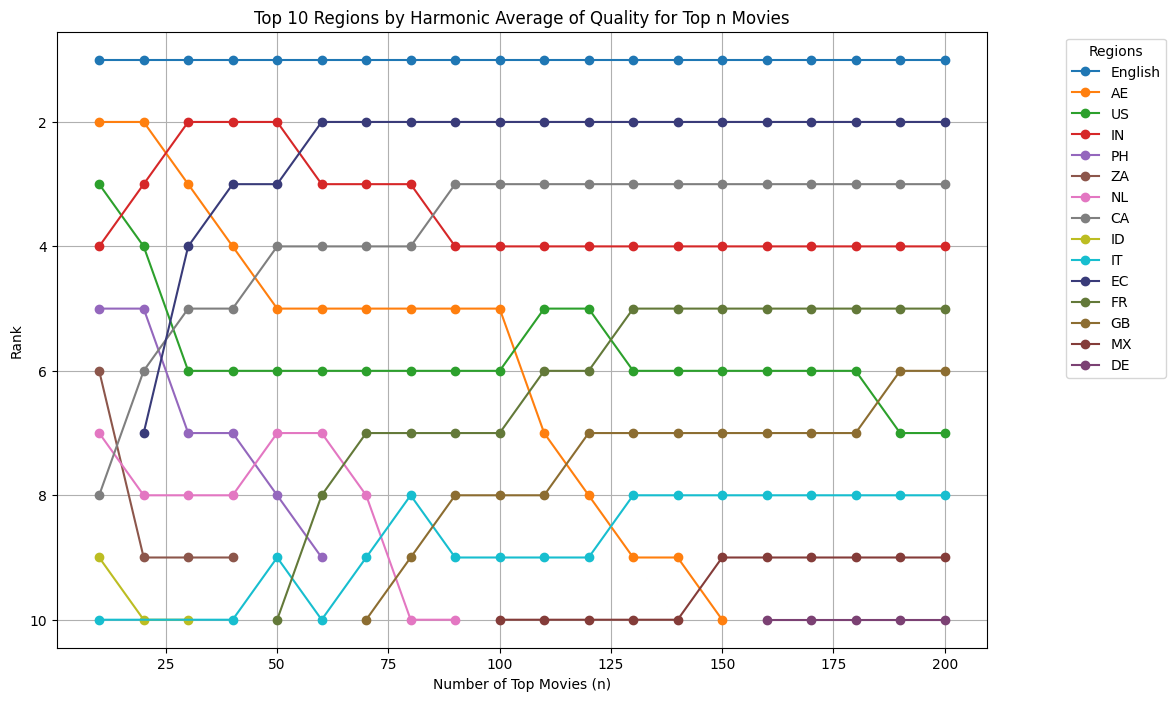

In [ ]:
# List to store results for plotting
region_rankings = {}

# Define a color palette with 20 colors
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#ce6dbd', '#6b6ecf', '#b5cf6b', '#bd9e39', '#9c9ede'
]

# Create a mapping of region to color
region_color_map = {}

# Loop over different values of n
for n in range(10, 210, 10):
    region_harmonic_averages = []

    # Calculate the harmonic average for each region
    for region, group in df_exploded.groupby('region'):
        if len(group) >= n:
            top_n_movies = group.nlargest(n, 'quality')
            harmonic_avg = ef.harmonic_average(top_n_movies['quality'])
            region_harmonic_averages.append((region, harmonic_avg))

    # Sort regions by harmonic average
    region_harmonic_averages.sort(key=lambda x: x[1], reverse=True)

    # Store the rankings
    for rank, (region, avg) in enumerate(region_harmonic_averages[:10], start=1):
        if region not in region_rankings:
            region_rankings[region] = []
        region_rankings[region].append((n, rank))
        # Assign a color to each region
        if region not in region_color_map:
            color_index = len(region_color_map) % len(colors)
            region_color_map[region] = colors[color_index]

# Plotting the rankings
plt.figure(figsize=(12, 8))
regions_to_plot = {region: ranks for region, ranks in region_rankings.items() if ranks}

for region, ranks in regions_to_plot.items():
    n_vals, rank_vals = zip(*ranks)
    plt.plot(n_vals, rank_vals, marker='o', label=region, color=region_color_map[region])

plt.gca().invert_yaxis()  # Invert y-axis to have rank 1 at the top
plt.xlabel('Number of Top Movies (n)')
plt.ylabel('Rank')
plt.title('Top 10 Regions by Harmonic Average of Quality for Top n Movies')
plt.legend(title='Regions', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Task 2
Na początku musimy znowu połączyć tabelę z numVotes, zeby policzyć weak impact

### Weak Impact

In [ ]:
weak_impact = df_exploded.merge(title_ratings, left_on='tconst', right_on='tconst', how='left')

In [ ]:
wi = weak_impact.groupby('region')['numVotes'].sum().reset_index()

# Sort by the sum of 'quality' in descending order to create a ranking
ranking_weak_impact = wi.sort_values(by='numVotes', ascending=False).reset_index(drop=True)

# Add a ranking column
ranking_weak_impact['Rank'] = ranking_weak_impact.index + 1

# Display the ranking
print(ranking_weak_impact)

print('Miejsce Polski w tym rankingu to: ', ranking_weak_impact[ranking_weak_impact['region'] == 'PL'].index + 1)


      region   numVotes  Rank
0    English  965052252     1
1         US   41246160     2
2         EC   34748963     3
3         CA   29992135     4
4         IN   29102487     5
..       ...        ...   ...
216       SC          9   217
217       GM          8   218
218       KM          8   219
219       EH          5   220
220       VU          5   221

[221 rows x 3 columns]
Miejsce Polski w tym rankingu to:  Index([33], dtype='int64')


### Strong impact

In [ ]:

region_harmonic_averages = df_exploded.groupby('region')['quality'].agg(ef.harmonic_average).reset_index()
region_harmonic_averages.columns = ['region', 'strongImpact']
region_harmonic_averages = region_harmonic_averages.sort_values(by='strongImpact', ascending=False)
region_harmonic_averages = region_harmonic_averages.reset_index()
region_harmonic_averages

,index,region,strongImpact
0,206,XAS,44.922941
1,1,AE,32.437994
2,56,EC,30.082130
3,211,XSA,29.604884
4,63,English,29.491090
...,...,...,...
216,203,VI,8.536413
217,166,SC,7.910008
218,77,GQ,7.734860
219,205,VU,7.403414


Mozna tez sprawdzić, ze dla średniej kwadratowej większe znaczenie ma liczba dobrych filmów niz szansa na "niefrafienie słabego dzieła".

In [ ]:
region_harmonic_averages = df_exploded.groupby('region')['quality'].agg(ef.quadratic_average).reset_index()
region_harmonic_averages.columns = ['region', 'strongImpact']
region_harmonic_averages = region_harmonic_averages.sort_values(by='strongImpact', ascending=False)
region_harmonic_averages = region_harmonic_averages.reset_index()
region_harmonic_averages['rankStrongIm'] = region_harmonic_averages['strongImpact'].rank(ascending=False, method='first')
region_harmonic_averages

,index,region,strongImpact,rankStrongIm
0,1,AE,46.481511,1.0
1,206,XAS,45.307982,2.0
2,56,EC,44.141597,3.0
3,118,LY,44.110860,4.0
4,63,English,41.102478,5.0
...,...,...,...,...
216,77,GQ,10.096492,217.0
217,103,KM,8.941599,218.0
218,166,SC,7.910008,219.0
219,205,VU,7.403414,220.0


Uzyjemy teraz danych ze strony World Bank Group https://datacatalog.worldbank.org/search/dataset/0038130 dotycząch GDP za rok 2024, które lekko nalezało przerobić, zeby mozna bylo poprawnie wczytac jako plik .csv.

In [ ]:
#GDP = pd.read_csv('GDP.csv')
GDP = GDP.rename(columns={'id': 'rankGDP', 'region' : 'regionGDP', ' GDP' : 'GDP'})
GDP.head(5)

,regionGDP,rankGDP,fullName,GDP,Unnamed: 4
0,USA,1.0,United States,"27,360,935",NaN
1,CHN,2.0,China,"17,794,782",NaN
2,DEU,3.0,Germany,"4,456,081",NaN
3,JPN,4.0,Japan,"4,212,945",NaN
4,IND,5.0,India,"3,549,919",NaN


W takim razie będziemy potrzebowali jeszcze znalezionego gdzieś przekładu ze skrótów 3 literowych na 2 literowe. Znaleziony na https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv zaimportujemy do naszego notatnika.

In [ ]:
abb = pd.read_csv('all.csv')
abb = abb.rename(columns={'alpha-3': 'regionAbb3', 'alpha-2': 'regionAbb2'})[['regionAbb3', 'regionAbb2']]
abb.head(5)


,regionAbb3,regionAbb2
0,AFG,AF
1,ALA,AX
2,ALB,AL
3,DZA,DZ
4,ASM,AS


Pobierzemy teraz dane dotyczące populacji ze strony https://www.kaggle.com/datasets/iamsouravbanerjee/world-population-dataset?resource=download.

In [ ]:
#pop = pd.read_csv('world_population.csv')
pop = pop[['Rank', 'CCA3', '2022 Population']]
pop = pop.rename(columns={'Rank': 'rankPop', 'CCA3': 'regionPop', '2022 Population': 'pop'})
pop.head(5)

,rankPop,regionPop,pop
0,36,AFG,41128771
1,138,ALB,2842321
2,34,DZA,44903225
3,213,ASM,44273
4,203,AND,79824


In [ ]:
task_2 = GDP.merge(abb, left_on='regionGDP', right_on='regionAbb3', how='left')
task_2 = task_2.merge(pop, left_on='regionGDP', right_on='regionPop', how='left')
task_2 = task_2.merge(region_harmonic_averages, left_on='regionAbb2', right_on='region', how='left')
task_2.dropna(subset=['regionAbb3', 'regionPop', 'region', 'GDP'])
number = "-"
print(ef.convert_gdp_format(number))
task_2['GDP'] = task_2['GDP'].apply(ef.convert_gdp_format)
task_2

nan


,regionGDP,rankGDP,fullName,GDP,Unnamed: 4,regionAbb3,regionAbb2,rankPop,regionPop,pop,index,region,strongImpact,rankStrongIm
0,USA,1.0,United States,27360935.0,NaN,USA,US,3.0,USA,3.382899e+08,196.0,US,27.031422,90.0
1,CHN,2.0,China,17794782.0,NaN,CHN,CN,1.0,CHN,1.425887e+09,41.0,CN,23.623550,146.0
2,DEU,3.0,Germany,4456081.0,NaN,DEU,DE,19.0,DEU,8.336984e+07,51.0,DE,29.138753,58.0
3,JPN,4.0,Japan,4212945.0,NaN,JPN,JP,11.0,JPN,1.239517e+08,99.0,JP,31.733479,29.0
4,IND,5.0,India,3549919.0,NaN,IND,IN,2.0,IND,1.417173e+09,92.0,IN,29.699887,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,PRK,NaN,"Korea, Dem. People's Rep.",NaN,NaN,PRK,KP,56.0,PRK,2.606942e+07,104.0,KP,19.477179,184.0
213,MNP,NaN,Northern Mariana Islands,NaN,NaN,MNP,MP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,SSD,NaN,South Sudan,NaN,NaN,SSD,SS,86.0,SSD,1.091316e+07,NaN,NaN,NaN,NaN
215,VEN,NaN,"Venezuela, RB",NaN,NaN,VEN,VE,51.0,VEN,2.830170e+07,201.0,VE,26.129335,103.0


In [ ]:

task_2['GDP_pop'] = task_2['GDP'] / task_2['pop']
task_2.sort_values('GDP_pop', ascending=False).reset_index()
task_2['rankGDP_pop'] = task_2.index + 1
task_2.dropna(subset=['GDP_pop', 'rankStrongIm'], inplace=True)
task_2['diff_Strong_GDP'] = task_2['rankStrongIm'] - task_2['rankGDP']
task_2

,regionGDP,rankGDP,fullName,GDP,Unnamed: 4,regionAbb3,regionAbb2,rankPop,regionPop,pop,index,region,strongImpact,rankStrongIm,GDP_pop,rankGDP_pop,diff_Strong_GDP
0,USA,1.0,United States,27360935.0,NaN,USA,US,3.0,USA,3.382899e+08,196.0,US,27.031422,90.0,0.080880,1,89.0
1,CHN,2.0,China,17794782.0,NaN,CHN,CN,1.0,CHN,1.425887e+09,41.0,CN,23.623550,146.0,0.012480,2,144.0
2,DEU,3.0,Germany,4456081.0,NaN,DEU,DE,19.0,DEU,8.336984e+07,51.0,DE,29.138753,58.0,0.053450,3,55.0
3,JPN,4.0,Japan,4212945.0,NaN,JPN,JP,11.0,JPN,1.239517e+08,99.0,JP,31.733479,29.0,0.033989,4,25.0
4,IND,5.0,India,3549919.0,NaN,IND,IN,2.0,IND,1.417173e+09,92.0,IN,29.699887,50.0,0.002505,5,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,VUT,194.0,Vanuatu,1126.0,NaN,VUT,VU,181.0,VUT,3.267400e+05,205.0,VU,7.403414,220.0,0.003446,194,26.0
197,ASM,198.0,American Samoa,871.0,NaN,ASM,AS,213.0,ASM,4.427300e+04,9.0,AS,11.982929,215.0,0.019673,198,17.0
200,STP,201.0,São Tomé and Principe,603.0,NaN,STP,ST,187.0,STP,2.273800e+05,177.0,ST,15.353583,207.0,0.002652,201,6.0
201,TON,202.0,Tonga,500.0,NaN,TON,TO,197.0,TON,1.068580e+05,189.0,TO,17.331521,202.0,0.004679,202,0.0


Sprawdźmy brakujące dane.

# Task 3
Porownamy moich ulubionych tworców: rezysera Wesa Andersona, aktora Christiana Bale'a oraz aktora Edwarda Nortona. Za pomocą dostępnej wiedzy o roku urodzenia tych tworcow znajduje ich w naszej bazie danych.

In [ ]:
name_basics = pliki[klucze[3]]
wes_and = name_basics[name_basics['primaryName'].str.contains('Wes Anderson', na=False) & name_basics['birthYear'].str.contains('1969', case=False, na=False)]
chr_bal = name_basics[name_basics['primaryName'].str.contains('Christian Bale', na=False) & name_basics['birthYear'].str.contains('1974', case=False, na=False)]
edw_nor = name_basics[name_basics['primaryName'].str.contains('Edward Norton', na=False) & name_basics['birthYear'].str.contains('1969', case=False, na=False)]

Zobaczmy w jakich filmach brali oni udział

In [ ]:
wes_and_movies = wes_and['knownForTitles'].iloc[0].split(',')
chr_bal_movies = chr_bal['knownForTitles'].iloc[0].split(',')
edw_nor_movies = edw_nor['knownForTitles'].iloc[0].split(',')


znajdzmy indeks naszych twórców

In [ ]:
print('Wes: ', wes_and['nconst'], ', Chris: ', chr_bal['nconst'], ', Edward: ', edw_nor['nconst'])

Wes:  26444    nm0027572
Name: nconst, dtype: object , Chris:  287    nm0000288
Name: nconst, dtype: object , Edward:  1568    nm0001570
Name: nconst, dtype: object


In [ ]:
title_akas = pliki[klucze[2]]
wes_and_title_akas = title_akas[title_akas['titleId'].isin(wes_and_movies)]
print(wes_and_title_akas[wes_and_title_akas['isOriginalTitle'] == 1]['title'])
chr_bal_title_akas = title_akas[title_akas['titleId'].isin(chr_bal_movies)]
print(chr_bal_title_akas[chr_bal_title_akas['isOriginalTitle'] == 1]['title'])
edw_nor_title_akas = title_akas[title_akas['titleId'].isin(edw_nor_movies)]
print(edw_nor_title_akas[edw_nor_title_akas['isOriginalTitle'] == 1]['title'])

1121984                                              Rushmore
1597204                                  The Royal Tenenbaums
2119652                                     Fantastic Mr. Fox
46454800    The French Dispatch of the Liberty, Kansas Eve...
Name: title, dtype: object
1937184             Batman Begins
2228783           The Dark Knight
13197211    The Dark Knight Rises
21655301          American Hustle
Name: title, dtype: object
1050723                                         Primal Fear
1083713                                  American History X
1155977                                          Fight Club
28443569    Birdman or (The Unexpected Virtue of Ignorance)
Name: title, dtype: object


In [ ]:
title_principals = pliki[klucze[1]]
ws_movies = title_principals[(title_principals['nconst'] == 'nm0027572') & (title_principals['category'] == 'director')]
ws_movies = ws_movies.merge(title_r_p, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
ws_movies = ws_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
ws_movies = ws_movies[ws_movies['titleType'].isin(['movie', 'tvMovie'])]
ws_movies =ws_movies[['tconst', 'nconst', 'quality', 'title']].drop_duplicates()
ws_movies = ws_movies.sort_values('quality', ascending=False)
ws_movies = ws_movies.head(10)
ws_movies

,tconst,nconst,quality,title
14,tt2278388,nm0027572,110.986955,The Grand Budapest Hotel
12,tt1748122,nm0027572,99.960888,Moonrise Kingdom
5,tt0432283,nm0027572,98.882968,Fantastic Mr. Fox
3,tt0265666,nm0027572,96.211758,The Royal Tenenbaums
25,tt5104604,nm0027572,94.904094,Isle of Dogs
2,tt0128445,nm0027572,92.727866,Rushmore
6,tt0838221,nm0027572,88.508759,The Darjeeling Limited
4,tt0362270,nm0027572,88.300746,The Life Aquatic with Steve Zissou
27,tt8847712,nm0027572,84.717930,"The French Dispatch of the Liberty, Kansas Eve..."
1,tt0115734,nm0027572,78.231875,Bottle Rocket


In [ ]:
title_principals = pliki[klucze[1]]
cb_movies = title_principals[(title_principals['nconst'] == 'nm0000288') & (title_principals['category'] == 'actor')]
cb_movies = cb_movies.merge(title_r_p, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
cb_movies = cb_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
cb_movies = cb_movies[cb_movies['titleType'].isin(['movie', 'tvMovie'])]
cb_movies = cb_movies[['quality', 'title']].drop_duplicates()
cb_movies = cb_movies.sort_values('quality', ascending=False)
cb_movies = cb_movies.head(10)
cb_movies

,quality,title
40,133.902098,The Dark Knight
53,121.175327,The Dark Knight Rises
42,120.601951,The Prestige
31,117.088274,Batman Begins
62,106.034848,Ford v Ferrari
17,102.552912,American Psycho
60,102.193366,The Big Short
44,100.431421,The Fighter
28,98.367963,The Machinist
33,96.633196,3:10 to Yuma


In [ ]:
title_principals = pliki[klucze[1]]
en_movies = title_principals[(title_principals['nconst'] == 'nm0001570') & (title_principals['category'] == 'actor')]
en_movies = en_movies.merge(title_r_p, left_on= 'tconst', right_on = 'tconst', how='left')
title_akas = title_akas[title_akas['isOriginalTitle'] == 1]
en_movies = en_movies.merge(title_akas, left_on='tconst', right_on='titleId', how='left')
en_movies = en_movies[en_movies['titleType'].isin(['movie', 'tvMovie'])]
en_movies = en_movies[['tconst', 'nconst', 'quality', 'title']].drop_duplicates()
en_movies = en_movies.sort_values('quality', ascending=False)
en_movies = en_movies.head(10)
en_movies

,tconst,nconst,quality,title
6,tt0137523,nm0001570,129.077869,Fight Club
4,tt0120586,nm0001570,118.932956,American History X
49,tt2278388,nm0001570,110.986955,The Grand Budapest Hotel
52,tt2562232,nm0001570,103.287682,Birdman or (The Unexpected Virtue of Ignorance)
45,tt1748122,nm0001570,99.960888,Moonrise Kingdom
18,tt0443543,nm0001570,96.571092,The Illusionist
2,tt0117381,nm0001570,95.673794,Primal Fear
66,tt5104604,nm0001570,94.904094,Isle of Dogs
36,tt11564570,nm0001570,92.387462,Glass Onion: A Knives Out Mystery
14,tt0307901,nm0001570,92.177177,25th Hour


In [ ]:
quality_values = ws_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Wes Anderson score is: ', ef.quadratic_average(quality_values))
quality_values = cb_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Christian Bale score is: ', ef.quadratic_average(quality_values))
quality_values = en_movies['quality']
quality_values = quality_values.dropna()
quality_values = np.array(quality_values)
print('Edward Norton score is: ', ef.quadratic_average(quality_values))

Wes Anderson score is:  93.74339818212866
Christian Bale score is:  110.53162462497926
Edward Norton score is:  104.06876839007269


# Task 3
## vol. 2
### Który gatunek filmów w Polsce jest najlepszy?


In [ ]:
grouped_df

,tconst,primaryTitle,quality,region
67708,tt0111161,The Shawshank Redemption,138.425646,[English]
159653,tt0468569,The Dark Knight,133.902098,[English]
38068,tt0068646,The Godfather,133.614143,[English]
87665,tt0167260,The Lord of the Rings: The Return of the King,130.551452,[English]
67516,tt0110912,Pulp Fiction,130.129220,[English]
...,...,...,...,...
285428,tt28670576,Bolandtarin Shabe Sal,1.791759,[IR]
282500,tt27833215,The Doll: Creation,1.609438,[PH]
290700,tt30625407,Borde Sagi,1.609438,[IR]
116926,tt0265845,Target World,1.609438,[GB]


In [ ]:
pol = grouped_df.copy()
pol['region'] = pol['region'].apply(lambda x: ','.join(x))

In [ ]:
#pol = grouped_df.explode('region')
pol = pol[pol['region'] == 'PL'] #interesuja nas tylko filmy, ktore na pewno sa polskie, a nie maja nieprzetlumaczony tytul
pol = pol.merge(title_basics, left_on='tconst', right_on='tconst', how='left')
pol = pol[pol['titleType'] == 'movie']
pol = pol[(pol['primaryTitle_x'] == pol['originalTitle'])]
pol

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
9,tt0090246,"Vabank II, czyli riposta",59.190168,PL,movie,"Vabank II, czyli riposta","Vabank II, czyli riposta",0,1985,\N,97,"Comedy,Crime"
10,tt0071907,Nie ma mocnych,57.728410,PL,movie,Nie ma mocnych,Nie ma mocnych,0,1974,\N,89,Comedy
15,tt0293901,Poranek kojota,55.701168,PL,movie,Poranek kojota,Poranek kojota,0,2001,\N,100,Comedy
20,tt0476872,Skazany na bluesa,53.869013,PL,movie,Skazany na bluesa,Skazany na bluesa,0,2005,\N,101,"Biography,Drama,Music"
24,tt0110908,Psy 2. Ostatnia krew,53.005871,PL,movie,Psy 2. Ostatnia krew,Psy 2. Ostatnia krew,0,1994,\N,100,"Action,Crime,Drama"
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,tt0072434,Zaczarowane podwórko,6.907755,PL,movie,Zaczarowane podwórko,Zaczarowane podwórko,0,1974,\N,98,"Family,Fantasy,Musical"
1458,tt15757700,Zly Demiurg,6.421503,PL,movie,Zly Demiurg,Zly Demiurg,0,2022,\N,120,Thriller
1460,tt1205603,Serce gór,6.044092,PL,movie,Serce gór,Serce gór,0,2004,\N,73,Adventure
1461,tt27866952,That Girl from Ukraine,5.526204,PL,movie,That Girl from Ukraine,That Girl from Ukraine,0,2023,\N,120,Drama


In [ ]:
pol['genres'] = pol['genres'].str.split(',')
pol = pol.explode('genres')
pol[['quality', 'genres']]

,quality,genres
9,59.190168,Comedy
9,59.190168,Crime
10,57.728410,Comedy
15,55.701168,Comedy
20,53.869013,Biography
...,...,...
1455,6.907755,Musical
1458,6.421503,Thriller
1460,6.044092,Adventure
1461,5.526204,Drama


In [ ]:
%%time
pol_gen = pol.groupby('genres')['quality'].apply(lambda x: ef.quadratic_average(x)).reset_index()
pol_gen.sort_values('quality', ascending=False)

CPU times: user 5.3 ms, sys: 13.2 ms, total: 18.5 ms
Wall time: 34.9 ms


,genres,quality
20,Western,29.334302
5,Crime,28.241902
12,Music,27.950782
3,Biography,27.233075
18,Thriller,26.333451
4,Comedy,26.263911
10,History,25.617519
2,Animation,25.444085
15,Romance,24.153690
14,Mystery,24.086857


In [ ]:
pol[pol['genres'] == 'Western']

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
218,tt0090760,Bolek i Lolek na Dzikim Zachodzie,34.747812,PL,movie,Bolek i Lolek na Dzikim Zachodzie,Bolek i Lolek na Dzikim Zachodzie,0,1986,\N,95,Western
258,tt0063806,Wilcze echa,32.793369,PL,movie,Wilcze echa,Wilcze echa,0,1968,\N,97,Western
998,tt0317445,Eukaliptus,17.282601,PL,movie,Eukaliptus,Eukaliptus,0,2002,\N,72,Western


In [ ]:
top_n = 10 #uwzględniamy jedynie te gatunki, ktore mają conajmniej 10 filmów, zeby nie porownywac polskich westernów, których są tylko 3
df_top_n = pol.groupby('genres').apply(
    lambda x: x.nlargest(top_n, 'quality') if len(x) >= top_n else pd.DataFrame(columns=x.columns)
).reset_index(drop=True)

region_harmonic_avg = df_top_n.groupby('genres')['quality'].apply(ef.harmonic_average).reset_index()
region_harmonic_avg.columns = ['genre', 'HarmonicAverage']

# Step 5: Sort the regions by harmonic average
region_harmonic_avg_sorted = region_harmonic_avg.sort_values(by='HarmonicAverage', ascending=False)

# Display the results
print(region_harmonic_avg_sorted)

          genre  HarmonicAverage
6         Drama        44.695429
3        Comedy        44.396948
9       Romance        33.286159
4         Crime        32.554952
5   Documentary        32.534023
0        Action        31.585021
8       History        30.098876
2     Biography        29.663615
10     Thriller        28.725017
11          War        27.896146
7        Family        21.935524
1     Adventure        20.809745


/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_11125/1396159430.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_top_n = pol.groupby('genres').apply(
/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_11125/1396159430.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_n = pol.groupby('genres').apply(


In [ ]:
pol[pol['genres'] == 'Drama'].sort_values('quality', ascending=False)

,tconst,primaryTitle_x,quality,region,titleType,primaryTitle_y,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
20,tt0476872,Skazany na bluesa,53.869013,PL,movie,Skazany na bluesa,Skazany na bluesa,0,2005,\N,101,Drama
24,tt0110908,Psy 2. Ostatnia krew,53.005871,PL,movie,Psy 2. Ostatnia krew,Psy 2. Ostatnia krew,0,1994,\N,100,Drama
26,tt0114626,Tato,52.656287,PL,movie,Tato,Tato,0,1995,\N,110,Drama
30,tt0078507,Wodzirej,51.308371,PL,movie,Wodzirej,Wodzirej,0,1978,\N,104,Drama
37,tt0380636,Pogoda na jutro,50.589510,PL,movie,Pogoda na jutro,Pogoda na jutro,0,2003,\N,95,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
1446,tt0091675,Okruchy wojny,7.783641,PL,movie,Okruchy wojny,Okruchy wojny,0,1986,\N,76,Drama
1447,tt0082224,Czwartki ubogich,7.649676,PL,movie,Czwartki ubogich,Czwartki ubogich,0,1982,\N,92,Drama
1450,tt0100398,Powrót wabiszczura,7.475339,PL,movie,Powrót wabiszczura,Powrót wabiszczura,0,1989,\N,96,Drama
1451,tt15067856,Maszyna Goldberga,7.433475,PL,movie,Maszyna Goldberga,Maszyna Goldberga,0,2023,\N,\N,Drama


In [ ]:
genre_harmonic_avg = df_top_n.groupby('genres')['quality'].apply(ef.harmonic_average).reset_index()
genre_harmonic_avg.columns = ['Genre', 'Score']

# Step 5: Extract the best, second best, second worst, and worst movies for each genre

# Apply the function to get movie details for each genre
movie_details = df_top_n.groupby('genres').apply(ef.get_best_and_worst_movies).reset_index()
movie_details.columns = ['Genre', 'Best', 'SecondBest']

# Step 6: Merge harmonic averages with movie details
final_df = pd.merge(genre_harmonic_avg, movie_details, on='Genre')

# Step 7: Sort the DataFrame by harmonic average
final_df_sorted = final_df.sort_values(by='Score', ascending=False)

# Display the final sorted DataFrame
print("\nFinal DataFrame:")
print(final_df_sorted)


Final DataFrame:
          Genre      Score       Best  SecondBest
6         Drama  44.695429  tt0476872   tt0110908
3        Comedy  44.396948  tt0090246   tt0071907
9       Romance  33.286159  tt1130862   tt0064825
4         Crime  32.554952  tt0090246   tt0110908
5   Documentary  32.534023  tt0116804  tt11550202
0        Action  31.585021  tt0110908   tt0122740
8       History  30.098876  tt0085916   tt0108172
2     Biography  29.663615  tt0476872   tt2185384
10     Thriller  28.725017  tt1969991   tt3948370
11          War  27.896146  tt0040012   tt0085916
7        Family  21.935524  tt2185384   tt0166227
1     Adventure  20.809745  tt0090760   tt0063806


/var/folders/0r/hq8l80pd28v6wlvr518j1g700000gn/T/ipykernel_11125/2509629600.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movie_details = df_top_n.groupby('genres').apply(ef.get_best_and_worst_movies).reset_index()
